# Human Activity Recognition Model - Part 3
## Reducing the number of features used, in order to optimise a machine learning human activity recognition model

#### Natasha Qayyum - 2021

Background: <br>
MEx is a multimodel dataset containing data for 7 different physiotherapy exercises performed by 30 subjects, recorded by four sensor modalities. This analysis utilises the data recorded by one of these modalities, the Sensing Tex Pressure Mat (sampling frequency 15Hz, frame size 32 * 16), which is both rich and sparse.

The aim is to intelligently select a subset of the 512 features, to train a machine learning (ML) model whilst demonstrating a beneficial application of Feature Selection in the pre-processing steps. The ML model seeks to predict which physiotherapy exercise a subject is performing on the pressure mat, according to sensor readings. 

Benefits of feature selection include:
- Reduced training times
- Reduced computational requirements
- Remove irrelevant features, for example those pressure points which have never picked up a signal
- Reduce overfitting, seperating the signal from the noise


### Importing dependency packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from timeit import default_timer as timer
import sklearn as sklearn

### Importing dataset and creating useful data frames

In [2]:
pm_df = pd.read_csv('all_pm_data.csv')
pm_df.rename(columns={'Unnamed: 0': 'SE_datapoint'}, inplace=True) 

In [3]:
#select data for one exercise performed by one subject
sub1ex2_df = pm_df.loc[(pm_df['Subject'] == 1) & (pm_df['Exercise'] == 2)]

In [4]:
#one exercise by one subject
#select only the pressure readings, which will be used as a starting point for feature reduction
sub1ex2 = sub1ex2_df.iloc[:, 6:518].copy()

In [5]:
# create df copy of only the sensor readings for all exercises and all subjects
#this will be used for the final feature selection.
#and will be used to split into training and testing data
pm_df_fs = pm_df.drop(columns = ['SE_datapoint', 'Subject', 'Exercise', 'a_Time', 'r_Time', 'Total_p'])

pm_df_fs.head()

,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,1_10,...,32_7,32_8,32_9,32_10,32_11,32_12,32_13,32_14,32_15,32_16
0,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,0.0,...,104.0,93.0,58.0,78.0,53.0,192.0,388.0,330.0,123.0,6.0
1,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,0.0,...,106.0,93.0,64.0,78.0,53.0,195.0,390.0,330.0,119.0,7.0
2,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,0.0,...,108.0,94.0,66.0,79.0,55.0,196.0,391.0,324.0,106.0,5.0
3,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,0.0,...,125.0,94.0,64.0,79.0,55.0,194.0,391.0,321.0,114.0,6.0
4,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,0.0,...,129.0,95.0,64.0,79.0,55.0,194.0,381.0,321.0,114.0,6.0


## Feature Selection
### Measuring the regularity and predictability of each feature using approximate entropy (ApEn), to aid selection of the most 'useful' dimensions for a ML model. 
Beginning with one subject and exercise to prove concept. This can then be applied to the entire dataset.

In [6]:
# define a function that calculates the approximate entropy
# from https://en.wikipedia.org/wiki/Approximate_entropy

def ApEn(U, m, r) -> float:
    """Approximate_entropy."""

    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [
            len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0)
            for x_i in x
        ]
        return (N - m + 1.0) ** (-1) * sum(np.log(C))

    N = len(U)

    return abs(_phi(m + 1) - _phi(m))

In [7]:
# calculate the ApEn for each feature

column_apen = []

for i in tqdm(range(len(sub1ex2.columns))):
    column_apen.append(ApEn(sub1ex2.iloc[:,i].values, 2, 3))
    
column_apen

  0%|          | 0/512 [00:00<?, ?it/s]

[0.27377374921694875,
 0.3913810531373896,
 0.6527378856128401,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.037800390895571315,
 0.5921682797801928,
 0.637593084542579,
 0.11361546581479731,
 0.6503871454794021,
 0.6156049946055591,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05578404516241961,
 0.5704501066086607,
 0.6413757384753813,
 0.06385116068627963,
 0.8630025492937188,
 0.6713658669724358,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.06919261842201879,
 0.45565711253578023,
 0.5987691807831199,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.002029697965761551,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0008963656278370515,
 0.0,
 0.0036621482632497246,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

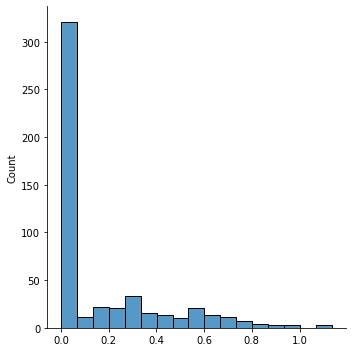

In [8]:
#plot the distribution of ApEn values
sns.displot(column_apen)

Over half of all features have an ApEn value of zero or near zero, meaning they are so regular that they are predictable all the time and offer no meaningful information.

In [9]:
#count the number of columns with ApEn = 0 and number with ApEn > 0.

numZeros = 0
numNonZeros = 0

for i in range(len(column_apen)):
    if column_apen[i] == 0:
        numZeros = numZeros + 1
    else:
        numNonZeros = numNonZeros + 1

print("Number of completely predictable columns: {}".format(numZeros))
print("Number of useful columns: {}".format(numNonZeros))

Number of completely predictable columns: 298
Number of useful columns: 214


In [10]:
#calculate the ApEn for a specified feature
ApEn(sub1ex2['1_1'].values, 2, 100) #parameters: m = 2 and r = 100. m represents the length of each compared run of data (essentially a window), and r specifies a filtering level.

0.0

### Using an out-the-box feature selection module to compare manual ApEn results to
Using Mutual Information (MI) regression. This method is an example of univariate feature selection, whereby the best features are selected based on univariate statistical tests. We compare each feature (pressure reading of a specific sensor) to the target variable (total pressure), to see whether there is any statistically significant relationship between them. It is also called analysis of variance (ANOVA), commonly used in Biological applications, where I first came across this methodology.

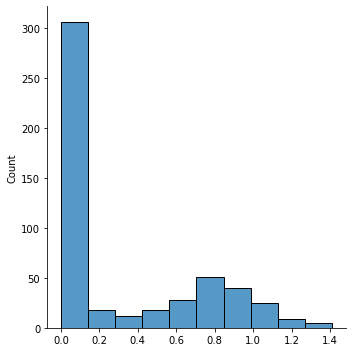

In [11]:
#calculating mutual information between each individual sensor result and the total pressure

from sklearn.feature_selection import mutual_info_classif

mutInf = sklearn.feature_selection.mutual_info_regression(sub1ex2.values, sub1ex2_df['Total_p'].values)

#plotting mutual information against number of features
sns.displot(mutInf)


Again, over half of all features show an MI of zero, indicating the features are independent of, and therefore have no impact on, the total pressure. A higher MI value indicates a higher dependency. <br><br>

### Begin dropping features
Reducing the dataframe in a stepwise manner by 30% each time.

In [12]:
#create a list of centiles that will be used to reduce the volume of features in the df

#100% of dataset reduced by 30% each time:
reduce = 0.3
current = 100
centiles = []

while current > 1:
    centiles.append(current)
    current = current * (1 - reduce)

print(centiles)

[100, 70.0, 49.0, 34.3, 24.009999999999998, 16.807, 11.764899999999999, 8.23543, 5.764800999999999, 4.035360699999999, 2.8247524899999994, 1.9773267429999994, 1.3841287200999994]


In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectPercentile, mutual_info_classif

X = pm_df_fs #all the pressure sensor features
Y = pm_df['Exercise'] #the target i.e. exercise number

print(X.shape)

start = timer()

X_list = []

for i in tqdm(range(len(centiles))):
    X_list.append(SelectPercentile(mutual_info_classif, centiles[i]).fit_transform(X, Y))
    print("Number of features retained: {}".format(X_list[i].shape[1]))

end = timer()
dt = end - start
print("Feature selecting time elapsed: {:.2f}s".format(dt))

(188116, 512)


  0%|          | 0/13 [00:00<?, ?it/s]

/Users/natasha/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass percentile=100 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Number of features retained: 512


/Users/natasha/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass percentile=70.0 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Number of features retained: 358


/Users/natasha/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass percentile=49.0 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Number of features retained: 251


/Users/natasha/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass percentile=34.3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Number of features retained: 176


/Users/natasha/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass percentile=24.009999999999998 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Number of features retained: 123


/Users/natasha/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass percentile=16.807 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Number of features retained: 86


/Users/natasha/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass percentile=11.764899999999999 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Number of features retained: 61


/Users/natasha/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass percentile=8.23543 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Number of features retained: 43


/Users/natasha/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass percentile=5.764800999999999 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Number of features retained: 30


/Users/natasha/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass percentile=4.035360699999999 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Number of features retained: 21


/Users/natasha/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass percentile=2.8247524899999994 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Number of features retained: 15


/Users/natasha/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass percentile=1.9773267429999994 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Number of features retained: 11


/Users/natasha/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass percentile=1.3841287200999994 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Number of features retained: 8
Feature selecting time elapsed: 7398.07s


In [14]:
#counting how many datasets we now have
#each set has 30% less features than the previous
list(range(len(centiles)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

### Running the 13 dataset volumes through a K-Nearest Neighbors Classifier
In this dataset, the type of exercise being performed by the subject is our target to be predicted. Because this is a discrete data type, it forms an interesting classification problem. <br>

The K-Nearest Neighbors classifier (KNN) will be used in this analysis - it is a simple supervised machine learning algorithm which utilises observations within known classes (labeled data in our training set which tells us what pressure measurements are typical of which exercises). It then compares these against observations (pressure readings) with an unknown class - matching them according to proximity. <br>

The true intention of this analysis is to prove feature selection can improve the performance of a model, with additional computational benefits as a by-product. More information does not necessarily produce a more accurate model, due to noise and over-fitting. <br>

The next steps are therefore to measure the levels of classification precision after reducing the sensor volume by 30% in a stepwise manner.

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [16]:
neigh = KNeighborsClassifier(n_neighbors=3)

fit_time = []
predict_time = []
reports = []

for i in range(len(centiles)): #for each volume of data
    start = timer()
    x_train, x_test, y_train, y_test = train_test_split(X_list[i], Y) #for each dataset in x_list (30% stepwise feature reduction), split the dataset into training and testing sets.
    neigh.fit(x_train, y_train) #run the training data through the KNN
    end = timer()
    fit_time.append(end - start) #record the training time. this will help us compare model performance
    print("Fitting time elapsed for {} columns: {:.2f}s".format(x_train.shape[1], fit_time[i]))
    
    start = timer()
    pred = neigh.predict(x_test) #run test data through our trained KNN to predict exercise performed
    end = timer()
    predict_time.append(end - start) #record the prediction time. this will help us compare model performance
    print("Predicting time elapsed: {:.2f}s".format(predict_time[i]))

    c_mat = confusion_matrix(y_test, pred) #compare the test predictions against the actual target (hidden to trained model). produce a confusion matrix.
    print("Confusion matrix:\n{}".format(c_mat))
    
    reports.append(classification_report(y_test, pred, output_dict = True)) #writes a report of results
    print(reports[i])
    
    print("\n\n")   

Fitting time elapsed for 512 columns: 1.31s
Predicting time elapsed: 217.22s
Confusion matrix:
[[7109    1   13    0    0    0    0]
 [   1 7669    1    0    2    0    0]
 [   0    4 7520    0    1    2    2]
 [   0    0    0 3808    1    0    0]
 [   0    0  468    0 6764    3    8]
 [   0    0  818    0    1 5774   32]
 [   0    0 1973    0    5   28 5021]]
{'1': {'precision': 0.9998593530239099, 'recall': 0.998034536010108, 'f1-score': 0.998946111150144, 'support': 7123}, '2': {'precision': 0.9993484493093563, 'recall': 0.9994786915157045, 'f1-score': 0.9994135661692839, 'support': 7673}, '3': {'precision': 0.6967478921523209, 'recall': 0.9988046221277727, 'f1-score': 0.8208710839428011, 'support': 7529}, '4': {'precision': 1.0, 'recall': 0.9997374639012864, 'f1-score': 0.9998687147170802, 'support': 3809}, '5': {'precision': 0.9985237673457337, 'recall': 0.9338671821068618, 'f1-score': 0.9651137903973747, 'support': 7243}, '6': {'precision': 0.9943172033752368, 'recall': 0.87154716

Fitting time elapsed for 61 columns: 0.14s
Predicting time elapsed: 94.93s
Confusion matrix:
[[7068    2    0    1   12    4    3]
 [   4 7492   16    0    2    0    1]
 [   1    4 7392    1   82    3    3]
 [   1    0    0 3807    2    1    2]
 [   2    3    1    0 7218   67   76]
 [   0    0    2    0 2847 3356  422]
 [   3    0    3    0 2440  530 4155]]
{'1': {'precision': 0.9984461082073739, 'recall': 0.9968970380818054, 'f1-score': 0.9976709718399323, 'support': 7090}, '2': {'precision': 0.9988001599786696, 'recall': 0.9969394544244844, 'f1-score': 0.9978689397975492, 'support': 7515}, '3': {'precision': 0.9970326409495549, 'recall': 0.9874432273577345, 'f1-score': 0.9922147651006712, 'support': 7486}, '4': {'precision': 0.9994749278025729, 'recall': 0.998426435877262, 'f1-score': 0.998950406717397, 'support': 3813}, '5': {'precision': 0.5727207807664841, 'recall': 0.9797746708293742, 'f1-score': 0.7228843264897344, 'support': 7367}, '6': {'precision': 0.8472607927291088, 'recall

Fitting time elapsed for 8 columns: 2.54s
Predicting time elapsed: 5.93s
Confusion matrix:
[[6430  112  120   40  127   20  210]
 [ 122 7055  114   28   43   39   96]
 [  77  117 7059    4   83   21  204]
 [  27   11    3 3733   21   17   10]
 [ 254   48   89   22 4763   30 2015]
 [  62   31   31    6  119  447 5930]
 [  82   90   92    6  150  245 6574]]
{'1': {'precision': 0.9115395520272186, 'recall': 0.9108938943193087, 'f1-score': 0.9112166088003968, 'support': 7059}, '2': {'precision': 0.9452036441586281, 'recall': 0.9410430839002267, 'f1-score': 0.9431187754829222, 'support': 7497}, '3': {'precision': 0.9401971230687267, 'recall': 0.9331130204890945, 'f1-score': 0.9366416771711007, 'support': 7565}, '4': {'precision': 0.9723886428757489, 'recall': 0.9767137624280482, 'f1-score': 0.9745464038637254, 'support': 3822}, '5': {'precision': 0.8976630229928383, 'recall': 0.6596039329732724, 'f1-score': 0.7604374550969906, 'support': 7221}, '6': {'precision': 0.5457875457875457, 'recall

In [17]:
#pull macro average precision results from the above reports into a list
macro_avg = []

for i in range(len(reports)):
    macro_avg.append(reports[i]['macro avg']['precision'])

In [18]:
list(macro_avg)

[0.9543573126023759,
 0.9760982327338864,
 0.9556312356678619,
 0.9734664881561547,
 0.9600498145139807,
 0.9355060963621299,
 0.9007119716688792,
 0.8992628401966637,
 0.8601715185161988,
 0.8647642096202077,
 0.8674828636798415,
 0.8465672671289496,
 0.8071299513205296]

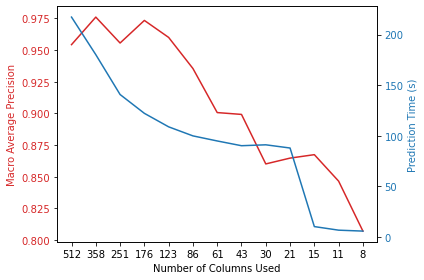

In [19]:
t = list(range(len(centiles)))

numCol = []
for i in range(len(X_list)):
    numCol.append(X_list[i].shape[1])
    
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Columns Used')
ax1.set_ylabel('Macro Average Precision', color=color)
ax1.plot(t, macro_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks(t, numCol)

ax2 = ax1.twinx() #instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Prediction Time (s)', color=color)  #already handled the x-label with ax1
ax2.plot(t, predict_time, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  #otherwise the right y-label is slightly clipped
plt.show()

There is an immediate increase in the macro average precision of the model upon removing 30% of features from the dataset. In addition to this, the time taken to make a prediction has decreased. 